In [1]:
'''
Notebook created by: Gabriele Sottocornola
for the M.Sc. class of Data & Text Mining
Università degli studi di Milano-bicocca
'''
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This python notebook guides you step-by-step through the construction of your first neural network models to adress the well-known MNIST task.
You will see how to import and pre-process data in order to feed them into a neural network classification model.
You will see how to contruct the two standard neural network models, namely feedforward neural network (FNN) and convolutional neural network (CNN) and you will perform simple evaluation on the classification accuracy of the two models with respect to the task of digit recognition.

### Utility Functions

In [2]:
def show_digit(gs_arr):
    gs_arr = np.reshape(gs_arr, (28, 28))
    plt.imshow(gs_arr, cmap='Greys')
    plt.show()

In [3]:
def plot_error(train_error_list, test_error_list, step_list):    
    train_err, = plt.plot(step_list, train_error_list, 'r-', label='Train set')
    test_err, = plt.plot(step_list, test_error_list, 'b-', label='Test set')
    plt.legend(handles=[train_err, test_err])
    plt.xlabel('Training iteration')
    plt.ylabel('Cross-entropy')
    plt.show()
    plt.gcf().clear()

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [5]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

### Data Import

In [6]:
data_df = pd.read_csv('.\\data\\MNIST.csv', header=0) # global MNIST dataframe
data_df = data_df.sample(frac=1) # shuffle data
label_df = data_df['label'] # extract label dataframe
label_df = pd.get_dummies(label_df) # one hot encoding of label dataframe
data_df = data_df.drop('label', axis=1)

num_instances = data_df.shape[0]
msk = np.random.rand(num_instances) < 0.8 # split train-test ratio

# hold-out split of the data
train_df = data_df[msk]
test_df = data_df[~msk]
train_label_df = label_df[msk]
test_label_df = label_df[~msk]

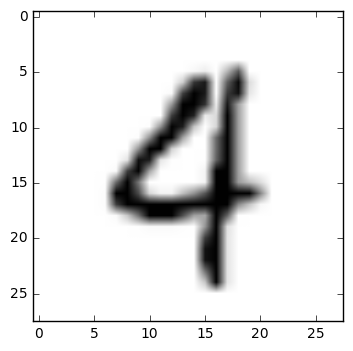

In [7]:
show_digit(train_df.iloc[1].tolist())

In [8]:
print(train_df.shape)
print(test_df.shape)

(33582, 784)
(8418, 784)


## MNIST - FNN

The model is a very simple FNN without any hidden layer. It only consists on one input layer with one neuron for each feature (pixel) of the image and one output layer with ten output neurons, one for each class (digits from 0 to 9).

In [10]:
# MODEL CONSTRUCTION (COMPUTATION GRAPH)
x = tf.placeholder(tf.float32, [None, 784])  # input data
W = weight_variable([784, 10])
b = bias_variable([10])
y = tf.matmul(x, W) + b  # predicted distribution tensor
y_ = tf.placeholder(tf.float32, [None, 10])  # target class

In [11]:
# LOSS FUNCTION AND TRAINING STEP
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)) # cross entropy loss function
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# EVALUATION
prediction = tf.argmax(y, 1) # predicted class
correct_prediction = tf.equal(prediction, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # computed accuracy

In [13]:
# COMPUTATION PHASE
num_iter = 1000
batch_size = 512

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# stochastic mini-batch learning
i = 1
while i <= num_iter:
    idx = np.random.choice(np.arange(train_df.shape[0]), batch_size, replace=False)
    batch_xs = train_df.iloc[idx]
    batch_ys = train_label_df.iloc[idx]
    
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch_xs, y_: batch_ys})
    i += 1

print("test accuracy %g" % accuracy.eval(feed_dict={x: test_df, y_: test_label_df}))

step 100, training accuracy 0.259766
step 200, training accuracy 0.394531
step 300, training accuracy 0.503906
step 400, training accuracy 0.613281
step 500, training accuracy 0.648438
step 600, training accuracy 0.699219
step 700, training accuracy 0.699219
step 800, training accuracy 0.755859
step 900, training accuracy 0.738281
step 1000, training accuracy 0.744141
test accuracy 0.766833


## MNIST - CNN

This model is much more complex than the previous one. We have exactly the same input (reshaped in a 2D fashion 28x28) but then we stack:
+ a convolutional layer with a size of 5x5 and 32 output filters
+ a max-pooling layer 2x2
+ a convolutional layer with a size of 5x5 and 64 output filters
+ a max-pooling layer 2x2
+ a fully connected layer with 1024 output neurons
+ a dropout layer with a drop probability of 0.5
+ the final output layer that receives 1024 features as input and output the 10 classes

In [9]:
# MODEL CONSTRUCTION (COMPUTATION GRAPH)
x = tf.placeholder(tf.float32, [None, 784])  # input data
y_ = tf.placeholder(tf.float32, [None, 10])  # target class

x_image = tf.reshape(x, [-1, 28, 28, 1]) # reshape 2d data

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [10]:
# LOSS FUNCTION AND TRAINING STEP
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)) # cross entropy loss function
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# EVALUATION
prediction = tf.argmax(y_conv, 1) #predicted class
correct_prediction = tf.equal(prediction, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # computed accuracy

In [11]:
# COMPUTATION PHASE
num_iter = 1000
batch_size = 512

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_error_list = list()
test_error_list = list()
step_list = list()

i = 1
while i <= num_iter:
    idx = np.random.choice(np.arange(train_df.shape[0]), batch_size, replace=False)
    batch_xs = train_df.iloc[idx]
    batch_ys = train_label_df.iloc[idx]
    
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
        train_err = cross_entropy.eval(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 1.0})
        test_err = cross_entropy.eval(feed_dict={x: test_df, y_: test_label_df, keep_prob: 1.0})
        train_error_list.append(train_err)
        test_error_list.append(test_err)
        step_list.append(i)
        
    train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
    i += 1

print("test accuracy %g" % accuracy.eval(feed_dict={x: test_df, y_: test_label_df, keep_prob: 1.0}))

step 100, training accuracy 0.923828
step 200, training accuracy 0.935547
step 300, training accuracy 0.972656
step 400, training accuracy 0.974609
step 500, training accuracy 0.964844
step 600, training accuracy 0.982422
step 700, training accuracy 0.96875
step 800, training accuracy 0.976562
step 900, training accuracy 0.982422
step 1000, training accuracy 0.986328
test accuracy 0.966738


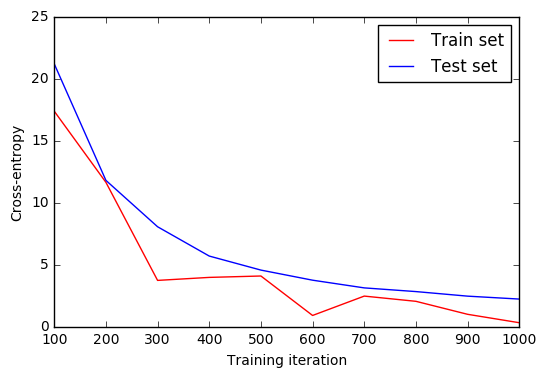

In [12]:
plot_error(train_error_list, test_error_list, step_list)

In [ ]:
##########################################################################################################################

## Take-aways

+ MNIST is the "hello world" task for machine learning image recognition

+ Very simple FNN achieves decent results on MNIST task

+ CNN strongly outperforms FNN in image recognition task

+ Few tricks from the "flat" NN model, i.e. convolution, max-pooling, dropout